<a href="https://colab.research.google.com/github/Robbysaidiii/Scraping_RobbySaidi_mc211d5y2136/blob/main/pelatihan_model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libarary yang dibutuhkn

In [21]:
!pip install Sastrawi
!pip install tensorflow
!pip install swifter
!pip install transformers
!pip install textblob
!pip install vaderSentiment

In [50]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from transformers import BertTokenizer, TFBertForSequenceClassification
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import swifter
from tqdm import tqdm
from joblib import Parallel, delayed
from textblob import TextBlob
from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


In [51]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Memuat Dataset

In [24]:

from google.colab import drive
drive.mount('/content/drive')
df=pd.read_csv('/content/drive/MyDrive/ulasan_aplikasi_twitter.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Exploratory Data Analysis (EDA)

In [52]:
df.head()

,userName,Rating,Review,Tanggal,review_length,tokens,cleaned_review,textblob_polarity,textblob_label,vader_compound,vader_label
0,Pengguna Google,2,banyak bug jadi lemot foto atau video sering n...,2025-03-11 15:06:40,34,"[bug, lot, foto, video, nggak, munculnggak, pu...",bug lot foto video nggak munculnggak puter wif...,0.000000,netral,0.0,netral
1,Pengguna Google,1,saya baru instal lagi x ini mau login eh memua...,2025-03-10 14:18:48,37,"[instal, x, login, eh, muat, udh, tunggu, meni...",instal x login eh muat udh tunggu menit salah ...,0.166667,positif,0.0,netral
2,Pengguna Google,1,semenjak jadi x malah lemot minta update serin...,2025-02-04 22:06:28,38,"[semenjak, x, lot, update, aplikasi, ga, baik,...",semenjak x lot update aplikasi ga baik refresh...,0.000000,netral,0.0,netral
3,Pengguna Google,4,kok banyak video permasalahan dan lemot padaha...,2025-01-15 13:22:01,46,"[video, masalah, lot, wifi, lancar, tolong, ba...",video masalah lot wifi lancar tolong baik undu...,0.000000,netral,0.0,netral
4,Pengguna Google,5,untuk pihak x mohon tambahkan fitur juga bisa ...,2025-03-04 18:53:12,34,"[x, mohon, tambah, fitur, mati, kolom, quote, ...",x mohon tambah fitur mati kolom quote post kut...,0.000000,netral,0.0,netral


dari dataframe diatas terdapat username, rating,review , tanggal

1.  (username) hanya berisi Pengguna Google yang artinya google menyembunyikan nama penggunna

2.   (Rating) memberika bintang sesuai dengan permasalahan user

3.  (Review) sebuah ekspersi user saat menggunkan aplikasi x/Twitter

4.  (Tanggal) setiap user yag memberika review dan rting akan tercatat tanggalnya



In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11111 entries, 0 to 11110
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   userName           11111 non-null  object        
 1   Rating             11111 non-null  int64         
 2   Review             11111 non-null  object        
 3   Tanggal            11111 non-null  datetime64[ns]
 4   review_length      11111 non-null  int64         
 5   tokens             11111 non-null  object        
 6   cleaned_review     11111 non-null  object        
 7   textblob_polarity  11111 non-null  float64       
 8   textblob_label     11111 non-null  object        
 9   vader_compound     11111 non-null  float64       
 10  vader_label        11111 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(6)
memory usage: 955.0+ KB


dari dataframe diatas terdapat 11110 data yang berisi 4 kolom dengan tipe data 3 object dan 1 int64.... ridak ada yang missing value

In [54]:
df['Rating'].value_counts()
df['userName'].nunique()

1

In [55]:
df.shape

(11111, 11)

In [29]:
df.Review.duplicated().sum()
df.userName.duplicated().sum()

np.int64(11110)

karna di dalam username semua nya sama jadi terkena duplikat tapi saya tidak hapus duplikat karna sangat penting untuk analisis

In [56]:
df.describe(include='all')

,userName,Rating,Review,Tanggal,review_length,tokens,cleaned_review,textblob_polarity,textblob_label,vader_compound,vader_label
count,11111,11111.000000,11111,11111,11111.000000,11111,11111,11111.000000,11111,11111.000000,11111
unique,1,NaN,11097,NaN,NaN,11059,11059,NaN,3,NaN,3
top,Pengguna Google,NaN,sangat membantu,NaN,NaN,[],,NaN,netral,NaN,netral
freq,11111,NaN,5,NaN,NaN,8,8,NaN,9930,NaN,8570
mean,NaN,1.988480,NaN,2022-10-15 18:12:08.851858432,28.755468,NaN,NaN,0.002677,NaN,-0.028099,NaN
min,NaN,1.000000,NaN,2018-09-12 10:33:03,1.000000,NaN,NaN,-1.000000,NaN,-0.923100,NaN
25%,NaN,1.000000,NaN,2021-01-02 16:32:52.500000,18.000000,NaN,NaN,0.000000,NaN,0.000000,NaN
50%,NaN,1.000000,NaN,2023-02-02 12:09:28,26.000000,NaN,NaN,0.000000,NaN,0.000000,NaN
75%,NaN,3.000000,NaN,2024-10-14 02:01:17.500000,36.000000,NaN,NaN,0.000000,NaN,0.000000,NaN
max,NaN,5.000000,NaN,2025-04-05 17:13:56,103.000000,NaN,NaN,1.000000,NaN,0.957100,NaN


1. userName
Jumlah total: 11.111

Unik: 1

Nilai paling umum: "Pengguna Google" (muncul di semua baris)

Insight:

Semua nama pengguna disamarkan.

Kolom userName tidak informatif untuk analisis, bisa diabaikan atau dibuang.

2. Rating
Tipe data: Numerik

Statistik:

Rata-rata (mean): 1.99

Standar deviasi: 1.43

Minimum: 1

Kuartil 25%: 1

Median (50%): 1

Kuartil 75%: 3

Maksimum: 5

Insight:

Distribusi rating berat ke arah negatif.

Median = 1 → lebih dari setengah user memberi bintang 1.

Hanya sebagian kecil yang memberi bintang 4–5.

3. Review
Jumlah total review: 11.111

Jumlah unik: 11.101

Review paling sering muncul: "Sangat membantu" (muncul 3 kali)

Insight:

Hampir semua review berbeda → sangat beragam.

Duplikasi sangat kecil (hanya 10 duplikat dari 11.111 data), bisa diabaikan atau dibersihkan jika perlu.

4. Tanggal
Jumlah tanggal unik: 11.107

Tanggal paling sering muncul: 2025-03-11 10:43:31 (muncul 2 kali)

Insight:

Data dikumpulkan dalam waktu yang cukup variatif.

Distribusi waktu cukup baik, tidak terfokus di satu hari.

 Kesimpulan EDA (Dataset 11.111 Review):
Sentimen pengguna cenderung negatif, mayoritas rating bintang 1.

Review sangat beragam dan organik.

Data waktu dan review cukup menyebar → bagus untuk analisis lanjutan seperti time-series atau tren.

Kolom userName bisa diabaikan karena tidak memberikan informasi tambahan.



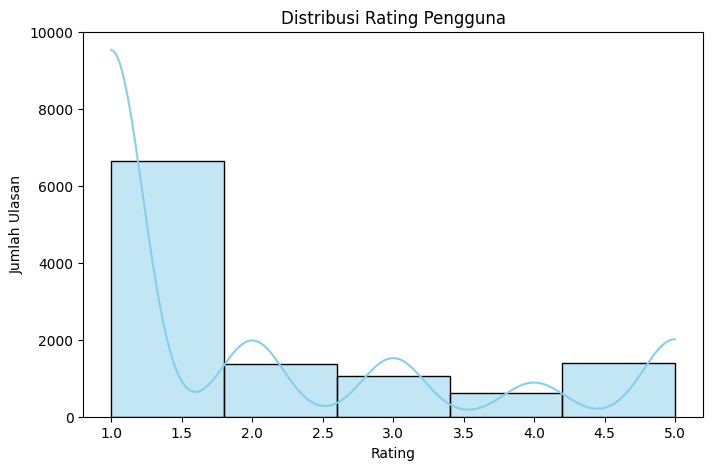

In [57]:

plt.figure(figsize=(8, 5))
sns.histplot(df['Rating'], bins=5, kde=True, color='skyblue')
plt.title('Distribusi Rating Pengguna')
plt.xlabel('Rating')
plt.ylabel('Jumlah Ulasan')
plt.show()

Mayoritas rating adalah 1 bintang — Ini menandakan banyak pengguna tidak puas dengan aplikasi (kemungkinan besar review-nya negatif).

Sedikit yang kasih 2–3 bintang — Artinya ulasan netral atau setengah-setengah itu jarang.

Rating tinggi (4–5) juga cukup signifikan — Menunjukkan ada juga yang puas atau sangat puas.

<Figure size 1000x600 with 0 Axes>

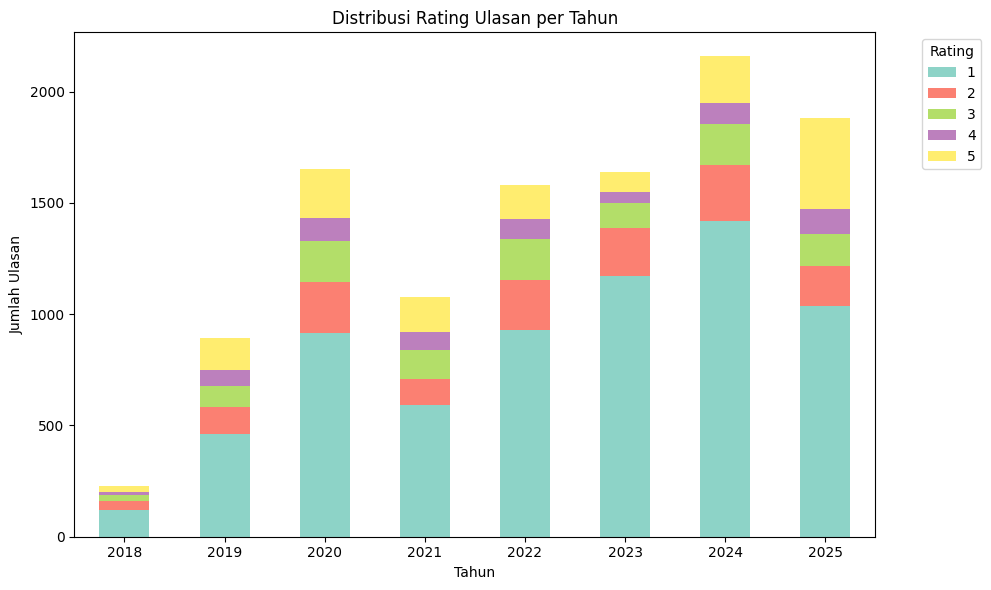

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pastikan kolom Tanggal dalam format datetime
df['Tanggal'] = pd.to_datetime(df['Tanggal'], errors='coerce')

# Group by tahun dan rating
rating_per_tahun = df.groupby([df['Tanggal'].dt.year, 'Rating']).size().unstack(fill_value=0)

# Plot
plt.figure(figsize=(10, 6))
rating_per_tahun.plot(kind='bar', stacked=True, colormap='Set3', figsize=(10, 6))

plt.title("Distribusi Rating Ulasan per Tahun")
plt.xlabel("Tahun")
plt.ylabel("Jumlah Ulasan")
plt.legend(title="Rating", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


Tahun 2020 & 2023 jadi tahun paling banyak ulasan.

Rating 1 (warna biru) mendominasi setiap tahun → ini menandakan banyak ulasan negatif dari pengguna.

Rating 5 (kuning) juga cukup signifikan di beberapa tahun, misalnya 2020 dan 2025.

Tahun 2018 masih sedikit aktivitas (wajar, mungkin awal-awal).

Tren dari 2019–2024 cukup stabil, tapi ulasan positif vs negatif masih jauh berbeda.

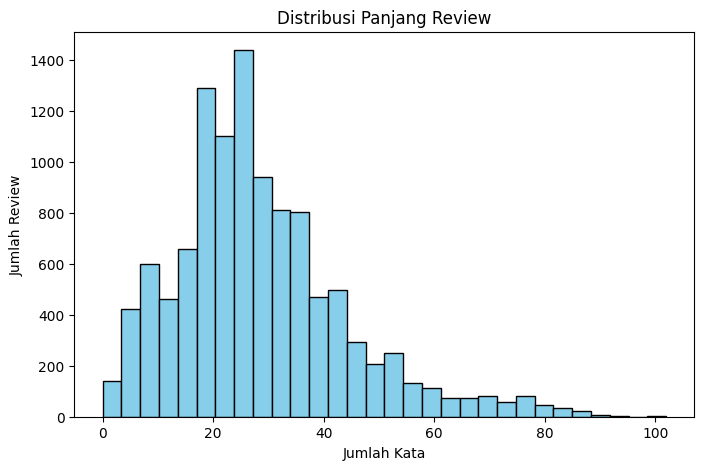

In [59]:
# --- EDA: Distribusi Panjang Teks ---
df['review_length'] = df['Review'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8,5))
plt.hist(df['review_length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribusi Panjang Review')
plt.xlabel('Jumlah Kata')
plt.ylabel('Jumlah Review')
plt.show()


dari hasil visualisasi panjang pesan review user yang paling banayak ada di 25 untuk panjang kata 60-100 hanya sedikit

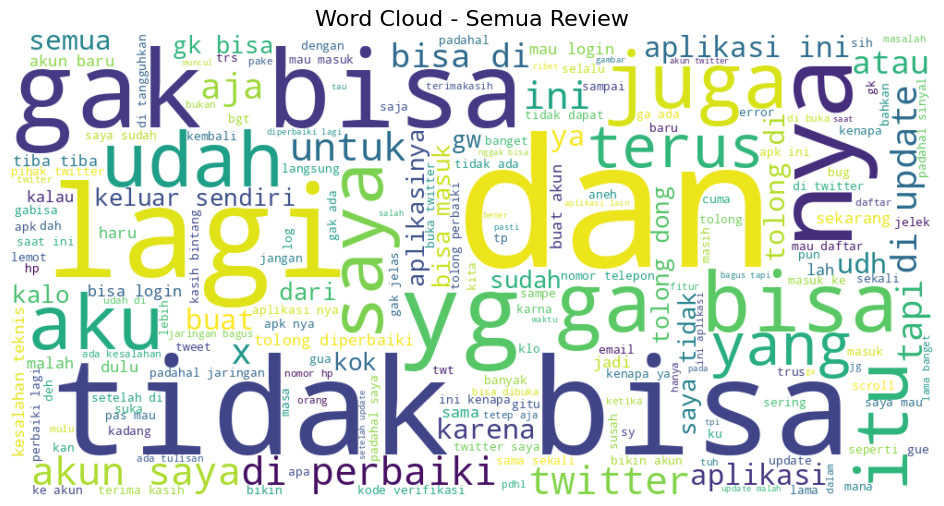

In [60]:
# Gabungkan semua teks review
text_all = ' '.join(df['Review'].astype(str))

# Buat Word Cloud
wordcloud_all = WordCloud(width=1000, height=500, background_color='white', colormap='viridis').generate(text_all)

# Tampilkan Word Cloud
plt.figure(figsize=(12,6))
plt.imshow(wordcloud_all, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Semua Review", fontsize=16)
plt.show()


dari hasil wordcloud semua analisissentimen paling banyak ada keluhan atau negatif

#  Pra-pemrosesan Teks

In [61]:
#Case Folding
df['Review'] = df['Review'].str.lower()

Mengubah semua huruf jadi huruf keci

In [62]:
#Remove Special Characters, Angka, dan Punctuation
df['Review'] = df['Review'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

Buang simbol, angka, dan tanda baca yang nggak penting.

In [63]:
#Tokenizing
df['tokens'] = df['Review'].apply(word_tokenize)

memecah kalimat menjadi potongan-potongan kata

In [64]:
stop_words = set(stopwords.words('indonesian'))
df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

Menghapus stopwords, yaitu kata-kata umum yang sering muncul tapi nggak punya makna penting dalam analisis

In [39]:
# Ambil semua kata dari seluruh token
all_words = [word for tokens in df['tokens'] for word in tokens]
unique_words = list(set(all_words))

# Inisialisasi stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Fungsi bantu untuk stemming
def stem_word(word):
    return word, stemmer.stem(word)

# Stemming paralel dengan joblib
stemmed_list = Parallel(n_jobs=-1)(delayed(stem_word)(word) for word in tqdm(unique_words))
stemmed_dict = dict(stemmed_list)

# Replace semua token pakai dictionary
df['tokens'] = df['tokens'].swifter.apply(lambda x: [stemmed_dict[word] for word in x])

100%|██████████| 15718/15718 [16:53<00:00, 15.51it/s]


Pandas Apply:   0%|          | 0/11111 [00:00<?, ?it/s]

bertujuan untuk melakukan proses stemming secara efisien pada data token dalam Bahasa Indonesia. Pertama, semua kata dari token di setiap review dikumpulkan menjadi satu list besar (all_words), kemudian diubah menjadi kumpulan kata unik (unique_words) agar tidak melakukan stemming berulang-ulang untuk kata yang sama. Selanjutnya, dibuat kamus stemming (stemmed_dict) dengan menggunakan Sastrawi Stemmer yang memetakan setiap kata unik ke bentuk dasarnya. Terakhir, setiap token dalam kolom df['tokens'] diganti dengan hasil stemming yang diambil dari kamus tersebut. Teknik ini membantu mempercepat proses stemming dan menjaga konsistensi hasil stemming di seluruh dataset.

# ekstraksi fitur dan pelabelan data

Fungsi ini menghasilkan teks yang lebih bersih dan representatif untuk analisis lebih lanjut seperti klasifikasi atau ekstraksi fitur.

In [67]:
# Inisialisasi hanya sekali
analyzer = SentimentIntensityAnalyzer()

# Fungsi hanya fokus mengembalikan skor
def get_vader_sentiment(text):
    return analyzer.polarity_scores(text)['compound']

# Terapkan ke kolom
df['vader_compound'] = df['cleaned_review'].apply(get_vader_sentiment)

# Label berdasarkan nilai polaritas TextBlob
def label_textblob(polarity):
    if polarity > 0:
        return 'positif'
    elif polarity < 0:
        return 'negatif'
    else:
        return 'netral'

df['textblob_label'] = df['textblob_polarity'].apply(label_textblob)

# Label berdasarkan nilai compound VADER
def label_vader(score):
    if score >= 0.05:
        return 'positif'
    elif score <= -0.05:
        return 'negatif'
    else:
        return 'netral'

df['vader_label'] = df['vader_compound'].apply(label_vader)


In [68]:
# 1. Gabungkan token hasil preprocessing
df['cleaned_review'] = df['tokens'].apply(lambda x: ' '.join(x))

# 2. Analisis sentimen
df['textblob_polarity'] = df['cleaned_review'].apply(get_textblob_polarity)
df['vader_compound'] = df['cleaned_review'].apply(get_vader_sentiment)


In [69]:
df[['Review', 'cleaned_review', 'textblob_polarity', 'textblob_label', 'vader_compound', 'vader_label']].head(50)


,Review,cleaned_review,textblob_polarity,textblob_label,vader_compound,vader_label
0,banyak bug jadi lemot foto atau video sering n...,bug lemot foto video nggak munculnggak keputer...,0.000000,netral,0.0000,netral
1,saya baru instal lagi x ini mau login eh memua...,instal x login eh memuat udh ditunggu menit ke...,0.166667,positif,0.0000,netral
2,semenjak jadi x malah lemot minta update serin...,semenjak x lemot update aplikasi ga membaik re...,0.000000,netral,0.0000,netral
3,kok banyak video permasalahan dan lemot padaha...,video permasalahan lemot wifi lancar tolong di...,0.000000,netral,0.0000,netral
4,untuk pihak x mohon tambahkan fitur juga bisa ...,x mohon tambahkan fitur mematikan kolom quote ...,0.000000,netral,0.0000,netral
5,pihak x tolong ini bug atau emang gitu di perb...,x tolong bug emang gitu perbaiki lihat posting...,0.000000,netral,0.0000,netral
6,sekarang buka reply postingan balasan dari ora...,buka reply postingan balasan orang ditemukan n...,0.000000,netral,0.0000,netral
7,aku coba dulu tapi bukan sekarang aku kasih ...,coba kasih tujuanku daftar twitter pelajari ve...,0.000000,netral,0.0000,netral
8,boleh saya memberi saran saya menggunakan twit...,saran twitter hp versi android oreo lag scroll...,0.000000,netral,-0.3400,negatif
9,kalau sudah update malah tambah ngeleg padahal...,update ngeleg wifi lancar susah nonton kadangk...,0.000000,netral,0.0000,netral


mengaktifkan fitur progress bar pada pandas.apply() sehingga saat fungsi preprocess_text diterapkan ke setiap review (df['Review']). Proses ini cukup berat karena melakukan normalisasi teks, tokenisasi, stopword removal, dan stemming untuk 11.111 baris data, yang terlihat memakan waktu sekitar 2,5 jam. Setelah teks dibersihkan dan disimpan dalam kolom cleaned_review, data diberi label sentimen: negatif (rating ≤ 2), netral (rating = 3), dan positif (rating ≥ 4). Label ini kemudian diencoding secara numerik dengan LabelEncoder agar bisa digunakan oleh model klasifikasi. Terakhir, hasil distribusi label ditampilkan, menunjukkan bahwa mayoritas review bersentimen negatif, sesuai dengan rata-rata rating rendah yang sebelumnya ditemukan di EDA.




*  Dataset memiliki tiga kelas.









# modeling

##  SKEMA PELATIHAN 1: LSTM + EMBEDDING



*   Menggunakan algoritma deep learning.



In [70]:
class TargetAccuracyCallback(Callback):
    def __init__(self, target_acc=0.92):
        super().__init__()
        self.target_acc = target_acc

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy')
        if val_acc is not None:
            if val_acc >= self.target_acc:
                print(f"\n🎉 Target val_accuracy {self.target_acc*100:.2f}% tercapai di epoch {epoch+1}, menghentikan training.")
                self.model.stop_training = True


In [71]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(df['cleaned_review'])
X_seq = tokenizer.texts_to_sequences(df['cleaned_review'])
X_seq = pad_sequences(X_seq, maxlen=100)


In [72]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X_seq, df['encoded_label'], test_size=0.2, stratify=df['encoded_label'], random_state=42
)

KeyError: 'encoded_label'

In [ ]:
#Model LSTM
model_lstm = Sequential([
    Embedding(20000, 128, input_length=100),
    LSTM(128, dropout=0.7, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_lstm = model_lstm.fit(
    X_train1, y_train1,
    validation_data=(X_test1, y_test1),
    epochs=30,
    batch_size=64,
    callbacks=[
        EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
        ModelCheckpoint('best_lstm.h5', monitor='val_accuracy', save_best_only=True),
        TargetAccuracyCallback(target_acc=0.95)
    ]
)


Berikut adalah penjelasan per bagian dari proses training model kamu berdasarkan grafik dan hasil epoch:

---

###  **Initial Performance (Epoch 1)**

- **Training Accuracy: 70.85%**, **Validation Accuracy: 77.37%**
- Ini menunjukkan bahwa model sudah cukup baik di awal, bahkan **val accuracy lebih tinggi daripada train**, yang cukup tidak biasa.
- Kemungkinan penyebab:
  - **Model arsitekturnya cocok** dengan pola dalam data.
  - **Inisialisasi bobot awal (initial weights)** cukup kuat.
  - Tapi perlu waspada, karena val acc > train acc bisa juga disebabkan oleh **data leakage** (misalnya data testing yang terlalu mirip dengan training).

---

###  **Rapid Improvement Phase (Epoch 2–3)**

- Train acc naik dari **79.15% ➝ 81.62%**, artinya model **belajar dengan cepat**.
- Val acc juga meningkat (meskipun lebih pelan): **78.45% ➝ 79.49%**
- Ini fase **pembelajaran aktif**, di mana model masih generalisasi dengan baik.
- **Gap antara train dan val tidak terlalu besar**, artinya belum ada overfitting.

---

###  **Peak Performance (Epoch 4)**

- **Train Accuracy: 82.68%**, **Val Accuracy: 79.26%**
- **Train Loss: 0.4825**, **Val Loss: 0.6093**
- Ini adalah titik **performansi paling seimbang**, karena model:
  - Memiliki akurasi tinggi pada kedua set.
  - Loss pada val dan train cukup dekat dan menunjukkan **konvergensi**.
- Bisa dianggap **epoch terbaik sebelum overfitting muncul**.

---

###  **Emerging Overfitting (Epochs 5–6)**

- **Train Accuracy meningkat terus** (84.61% ➝ 86.24%)
- Tapi **Validation Accuracy stagnan bahkan menurun** (78.36% ➝ 78.00%)
- **Train Loss menurun**, tapi **Val Loss naik** → tanda klasik **overfitting**
- Artinya: model terlalu fokus ke data training dan mulai **gagal generalisasi ke data baru**

---

###  **Kesimpulan Insight**

- Model menunjukkan potensi sangat baik dan cocok untuk task ini.
- Namun, performa terbaik hanya sampai **epoch 3–4**, setelah itu mulai overfit.
- Solusi:
  - Terapkan **early stopping** di sekitar epoch ke-3.
  - Tambahkan **Dropout/L2 Regularization**.
  - Atau pertimbangkan fine-tuning **pretrained model** seperti IndoBERT untuk performa lebih stabil.

Kalau kamu mau, aku bisa bantu hitung skor evaluasi lebih lanjut (precision, recall, F1) atau buatkan confusion matrix-nya juga. Mau lanjut ke situ?

In [ ]:

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Insight dari Grafik (Accuracy & Loss per Epoch)

1. Akurasi Training meningkat stabil dari epoch 0 hingga 5 (0.73 ➝ 0.86), menandakan model belajar dari data dengan baik.

2. Val Accuracy stagnan & mulai menurun sejak epoch ke-3, dari 0.79 ➝ 0.78. Ini indikasi awal overfitting.

3. Train Loss terus turun, tapi Val Loss mulai naik setelah epoch ke-2. Ini semakin memperkuat dugaan bahwa model overfitting setelah titik tersebut.

4. Epoch optimal kemungkinan besar ada di epoch ke-2 atau ke-3, karena di titik itu model masih seimbang antara belajar dan generalisasi.



##  SKEMA PELATIHAN 2: CNN + TF-IDF



*   Menggunakan algoritma deep learning.



In [ ]:
tfidf = TfidfVectorizer(max_features=20000)
X_tfidf = tfidf.fit_transform(df['cleaned_review']).toarray()

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X_tfidf, df['encoded_label'], test_size=0.2, stratify=df['encoded_label'], random_state=42
)

In [ ]:
tfidf = TfidfVectorizer(max_features=20000)
X_tfidf = tfidf.fit_transform(df['cleaned_review']).toarray()

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X_tfidf, df['encoded_label'], test_size=0.2, stratify=df['encoded_label'], random_state=42
)

X_train2 = X_train2.reshape(X_train2.shape[0], X_tfidf.shape[1], 1)
X_test2 = X_test2.reshape(X_test2.shape[0], X_tfidf.shape[1], 1)

model_cnn = Sequential([
    Conv1D(128, 5, activation='relu', input_shape=(X_tfidf.shape[1], 1)),
    BatchNormalization(),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    BatchNormalization,
    Dropout(0.5),
    Dense(3, activation='softmax')
])
model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_cnn = model_cnn.fit(
    X_train2, y_train2,
    validation_data=(X_test2, y_test2),
    epochs=10,
    batch_size=64,
    callbacks=[
        EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
        ModelCheckpoint('best_cnn.h5', monitor='val_accuracy', save_best_only=True),
         TargetAccuracyCallback(target_acc=0.95)
    ]
)


In [ ]:

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## SKEMA PELATIHAN 3: INDOBERT



*   Menggunakan algoritma deep learning.



In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
X_bert = bert_tokenizer(
    df['cleaned_review'].tolist(),
    truncation=True,
    padding=True,
    max_length=100,
    return_tensors='tf'
)

X_train3, X_test3, y_train3, y_test3 = train_test_split(
    X_bert['input_ids'],
    to_categorical(df['encoded_label']),
    test_size=0.2,
    stratify=df['encoded_label'],
    random_state=42
)

In [ ]:


model_bert = TFBertForSequenceClassification.from_pretrained(
    'indobenchmark/indobert-base-p1',
    num_labels=3
)

model_bert.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
history_bert = model_bert.fit(
    X_train3, y_train3,
    validation_data=(X_test3, y_test3),
    epochs=3,
    batch_size=16,
    callbacks=[
        EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True),
        ModelCheckpoint('best_bert', monitor='val_accuracy', save_best_only=True),
         TargetAccuracyCallback(target_acc=0.95)
    ]
)


## 6. EVALUASI SEMUA MODEL

In [ ]:
def evaluate_model(model, X_train, X_test, y_train, y_test, is_bert=False):
    if is_bert:
        y_train = np.argmax(y_train, axis=1)
        y_test = n    p.argmax(y_test, axis=1)
        train_acc = model.evaluate(X_train, to_categorical(y_train), verbose=0)[1]
        test_acc = model.evaluate(X_test, to_categorical(y_test), verbose=0)[1]
    else:
        train_acc = model.evaluate(X_train, y_train, verbose=0)[1]
        test_acc = model.evaluate(X_test, y_test, verbose=0)[1]
    return train_acc, test_acc

results = {
    'Model': ['LSTM', 'CNN+TF-IDF', 'IndoBERT'],
    'Training Accuracy': [
        evaluate_model(model_lstm, X_train1, X_test1, y_train1, y_test1)[0],
        evaluate_model(model_cnn, X_train2, X_test2, y_train2, y_test2)[0],
        evaluate_model(model_bert, X_train3, X_test3, y_train3, y_test3, is_bert=True)[0]
    ],
    'Testing Accuracy': [
        evaluate_model(model_lstm, X_train1, X_test1, y_train1, y_test1)[1],
        evaluate_model(model_cnn, X_train2, X_test2, y_train2, y_test2)[1],
        evaluate_model(model_bert, X_train3, X_test3, y_train3, y_test3, is_bert=True)[1]
    ]
}

pd.set_option('display.float_format', lambda x: '%.4f' % x)
results_df = pd.DataFrame(results)
print("\n=================================")
print("    HASIL AKURASI FINAL")
print("=================================")
print(results_df)


## 7. INFERENCE CONTOH

In [ ]:
def predict_sentiment(text, model, tokenizer, is_bert=False):
    text_cleaned = preprocess_text(text)
    if is_bert:
        inputs = bert_tokenizer(text_cleaned, return_tensors='tf', truncation=True, padding=True, max_length=100)
        pred = model.predict(dict(inputs)).logits
    else:
        seq = tokenizer.texts_to_sequences([text_cleaned])
        padded = pad_sequences(seq, maxlen=100)
        pred = model.predict(padded)
    label_idx = np.argmax(pred)
    return label_encoder.inverse_transform([label_idx])[0]

# Contoh inference
sample_texts = [
    "Aplikasinya sangat lambat dan sering error",
    "Lumayan bagus tapi ada bug minor",
    "Sangat puas dengan update terbaru!"
]

print("\n=================================")
print("      CONTOH INFERENCE")
print("=================================")
for text in sample_texts:
    print(f"\nText: '{text}'")
    print(f"LSTM Prediction: {predict_sentiment(text, model_lstm, tokenizer)}")
    print(f"CNN Prediction: {predict_sentiment(text, model_cnn, tfidf)}")
    print(f"BERT Prediction: {predict_sentiment(text, model_bert, bert_tokenizer, is_bert=True)}")